<a href="https://colab.research.google.com/github/flokoafon/WQU_project/blob/WQU1/WQU_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install arch

In [33]:
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import io
import datetime
import statsmodels.api as sm
from google.colab import files
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
import arch.unitroot as at
from statsmodels.tsa.stattools import grangercausalitytests
from  statsmodels.tsa.vector_ar.vecm import coint_johansen 
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
from  statsmodels.tsa.vector_ar.vecm import VECM
from statsmodels.stats.stattools import durbin_watson
from pandas.plotting import register_matplotlib_converters

In [2]:
url = "https://raw.githubusercontent.com/flokoafon/WQU_project/main/ProjectData.xlsx"
series = pd.read_excel(url)
series.head()

,Date,DPI,IPI,COP,SIR,LTIR,NGP
0,2000-01-01,6835.600098,76.49362,27.01,3.09,5.539524,NaN
1,2000-02-01,7644.549805,78.39347,29.30,3.14,5.508571,NaN
2,2000-03-01,7599.390137,78.49346,29.89,3.36,5.333043,NaN
3,2000-04-01,7414.680176,79.49338,25.54,3.53,5.225556,NaN
4,2000-05-01,7109.669922,81.39322,28.81,3.87,5.378182,NaN


In [3]:
series.tail()

,Date,DPI,IPI,COP,SIR,LTIR,NGP
262,2021-11-01,15100.129883,94.29214,79.18,-0.52,-0.313636,NaN
263,2021-12-01,15884.860352,95.79202,71.69,-0.58,-0.384286,NaN
264,2022-01-01,15471.200195,96.39197,82.98,-0.50,-0.114762,NaN
265,2022-02-01,14461.019531,96.49196,91.63,-0.48,0.150000,NaN
266,2022-03-01,14414.750000,NaN,108.26,NaN,0.280000,NaN


As you'll see it in the report, the abreviations used above have the following meanings:
DPI: Dax Performance Index
IPI: Industrial Production Index
COP: Crude Oil Price
SIR: Short term Interest Rate
LTIR: Long-Term Interest Rate
NGP: Natural Gas Price

In [4]:
#Defining date column as index
#series['Date'] = pd.to_datetime(series['Date'], dayfirst = True)
series.set_index('Date', inplace = True)
series

,DPI,IPI,COP,SIR,LTIR,NGP
Date,,,,,,
2000-01-01,6835.600098,76.49362,27.01,3.09,5.539524,NaN
2000-02-01,7644.549805,78.39347,29.30,3.14,5.508571,NaN
2000-03-01,7599.390137,78.49346,29.89,3.36,5.333043,NaN
2000-04-01,7414.680176,79.49338,25.54,3.53,5.225556,NaN
2000-05-01,7109.669922,81.39322,28.81,3.87,5.378182,NaN
...,...,...,...,...,...,...
2021-11-01,15100.129883,94.29214,79.18,-0.52,-0.313636,NaN
2021-12-01,15884.860352,95.79202,71.69,-0.58,-0.384286,NaN
2022-01-01,15471.200195,96.39197,82.98,-0.50,-0.114762,NaN


The variables DPI, IPI and COP are not at the same scale as the others so we have to rescale those variables in order to have the same scale in the database.

In [5]:
#Select date where all series are available
#This because npg serie is only available between 01/01/2007 and 01/06/2021
intermediate = series.reset_index()
first = intermediate.loc[intermediate['Date']=='2007-01-01']
last = intermediate.loc[intermediate['Date']=='2021-06-01']
begin = first.index[0]
end = last.index[0]
complete_series = intermediate.loc[begin:end,]
complete_series.set_index('Date', inplace = True)

In [6]:
#Complete_series is the dateframe containing all the rows of series with available data
complete_series

,DPI,IPI,COP,SIR,LTIR,NGP
Date,,,,,,
2007-01-01,6789.109863,95.09208,54.35,3.48,4.016818,2.4168
2007-02-01,6715.439941,95.49204,59.39,3.50,4.049000,2.4168
2007-03-01,6917.029785,95.99200,60.74,3.67,3.940909,2.4168
2007-04-01,7408.870117,95.09208,64.04,3.72,4.152105,2.4168
2007-05-01,7883.040039,96.79193,63.53,3.76,4.279048,2.4168
...,...,...,...,...,...,...
2021-02-01,13786.290039,95.19207,59.06,-0.26,-0.445500,2.0592
2021-03-01,15008.339844,95.89201,62.36,-0.12,-0.364783,2.0592
2021-04-01,15135.910156,95.69202,61.70,-0.25,-0.325000,2.0592


In the following cells, we plot the different series in order to have first apppreciations of their behaviors

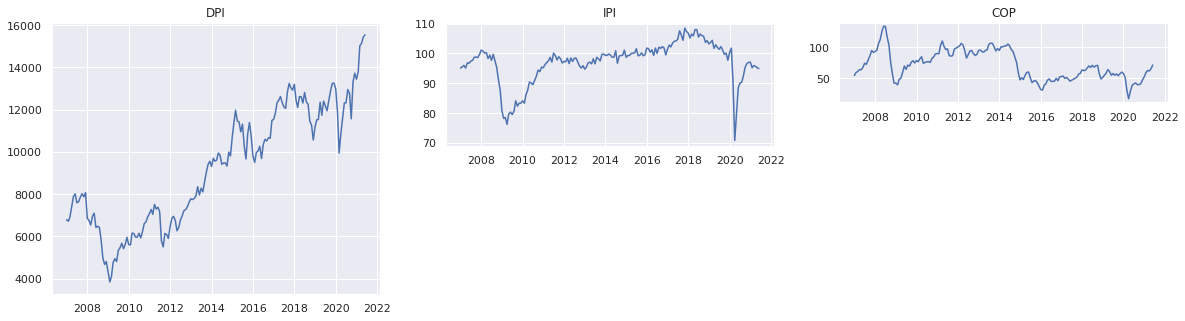

In [7]:
# First visualization of the series
sns.set()
plt.figure(1,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.plot(complete_series["DPI"])
plt.title("DPI")
plt.subplot(2, 3, 2)
plt.plot(complete_series["IPI"])
plt.title("IPI")
plt.subplot(3, 3, 3)
plt.plot(complete_series["COP"])
plt.title("COP")
plt.show()

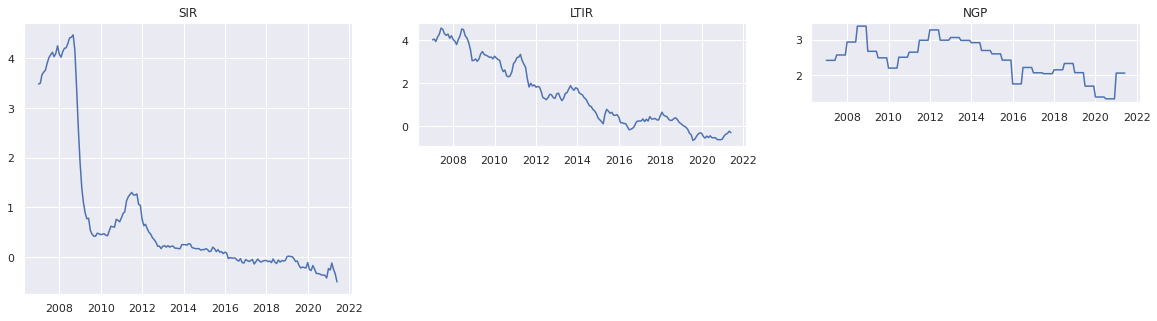

In [8]:
plt.figure(1,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.plot(complete_series["SIR"])
plt.title("SIR")
plt.subplot(2, 3, 2)
plt.plot(complete_series["LTIR"])
plt.title("LTIR")
plt.subplot(3, 3, 3)
plt.plot(complete_series["NGP"])
plt.title("NGP")
plt.show()

In [9]:
# Compute some descriptive statistics
complete_series.describe()

,DPI,IPI,COP,SIR,LTIR,NGP
count,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000
mean,9250.055925,97.155123,70.948851,0.735115,1.472843,2.441931
std,2808.160486,6.851241,23.458645,1.363454,1.555699,0.514635
min,3843.739990,70.794100,16.700000,-0.500000,-0.649091,1.337200
25%,6804.769897,95.492040,51.185000,-0.070000,0.233074,2.071700
50%,9472.234863,98.691770,67.690000,0.180000,1.279188,2.487600
75%,11691.842285,101.091600,92.715000,0.755000,3.018826,2.914000
max,15531.040039,108.491000,134.020000,4.470000,4.560476,3.378000


Transformation of DPI, IPI and COP with the log function in order to ensure the same scale with  SIR, LTIR and NGP

In [10]:
#Transformation
complete_series["logDPI"] = np.log(complete_series["DPI"])
complete_series["logIPI"] = np.log(complete_series["IPI"])
complete_series["logCOP"] = np.log(complete_series["COP"])

# descriptive statistics on transformed variables
complete_series[["logDPI","logIPI","logCOP"]].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,logDPI,logIPI,logCOP
count,174.000000,174.000000,174.000000
mean,9.083223,4.573644,4.203690
std,0.321260,0.074657,0.352128
min,8.254201,4.259776,2.815409
25%,8.825371,4.559043,3.935444
50%,9.156120,4.592002,4.214936
75%,9.366633,4.616027,4.529522
max,9.650596,4.686667,4.897989


## Train test split

In [179]:
# Split of data : train and test samples
train= complete_series.iloc[:-12] # From 2007-01-01 to 2020-06-01
test=complete_series.iloc[-12:] # The last 12 months ( from 2020-07-01 to 2021-06-01)
train.tail()

,DPI,IPI,COP,SIR,LTIR,NGP,logDPI,logIPI,logCOP
Date,,,,,,,,,
2020-02-01,11890.349609,101.79150,50.54,-0.25,-0.466000,1.3875,9.383482,4.622927,3.922765
2020-03-01,9935.839844,90.59245,30.45,-0.27,-0.541364,1.3875,9.203904,4.506371,3.416086
2020-04-01,10861.639648,70.79410,16.70,-0.17,-0.449500,1.3875,9.292993,4.259776,2.815409
2020-05-01,11586.849609,79.19340,28.53,-0.24,-0.516500,1.3875,9.357626,4.371893,3.350956
2020-06-01,12310.929688,88.39263,38.31,-0.33,-0.434286,1.3875,9.418243,4.481789,3.645711


# Studies on train sample

## Stationarity study

### Seasonnality
In the followings we study seasonnality of each series by using monthplots

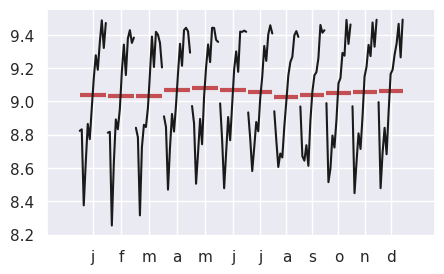

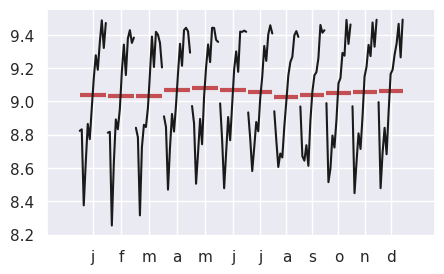

In [180]:
#Monthplot for DPI
sm.graphics.tsa.month_plot(train["logDPI"])

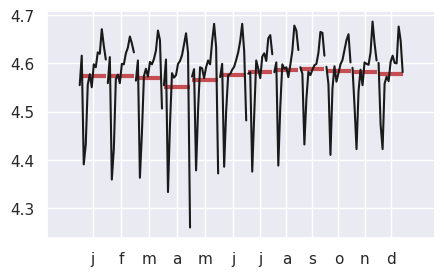

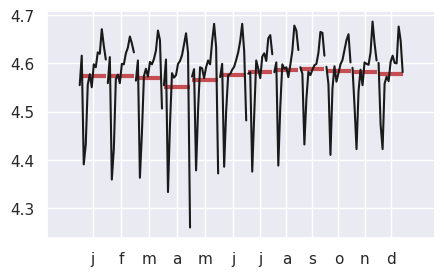

In [181]:
#Monthplot for IPI
sm.graphics.tsa.month_plot(train["logIPI"])

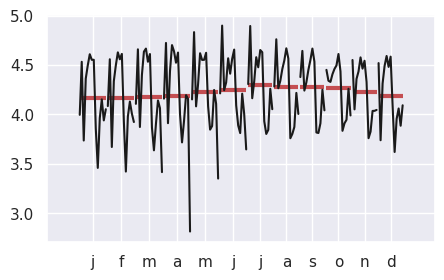

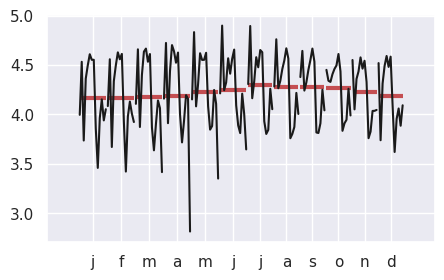

In [182]:
#Monthplot for COP
sm.graphics.tsa.month_plot(train["logCOP"])

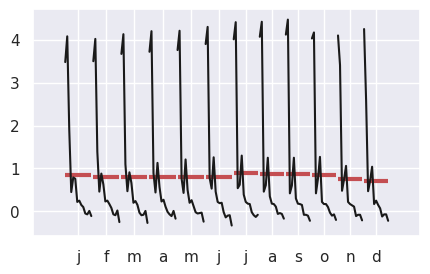

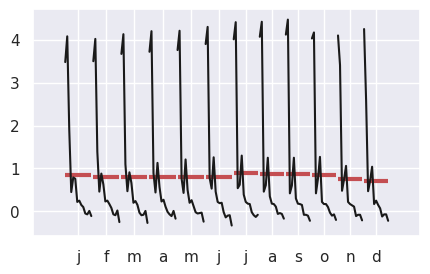

In [183]:
#Monthplot for SIR
sm.graphics.tsa.month_plot(train["SIR"])

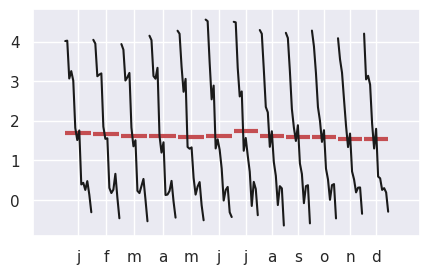

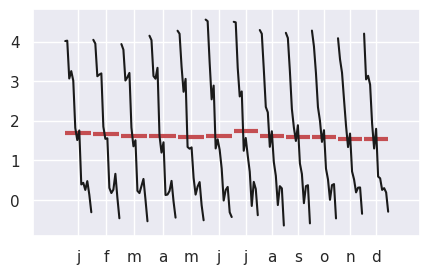

In [184]:
#Monthplot for LTIR
sm.graphics.tsa.month_plot(train["LTIR"])

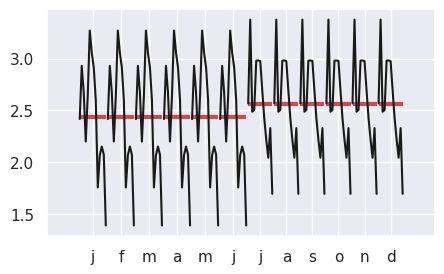

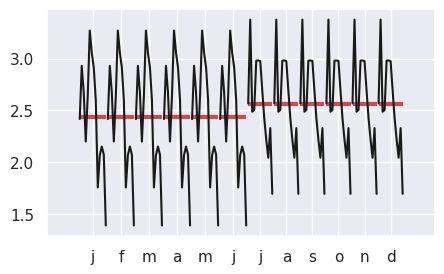

In [185]:
#Monthplot for NGP
sm.graphics.tsa.month_plot(train["NGP"])

As we can see it, almost series don't have a seasonnal component. But the series of DPI, SIR and LTIR seem to present trends and thus are not stationnary.The other series do not present trend but have values that far differ from their initial values with time. That is the sign of an unconstant variance and thus they are not stationnary. But we will perform unit root testing using Augmented Dickey-Fuller Test to confirm all of this.

### Autocorrelation and partial autocorrelation with functions complete series

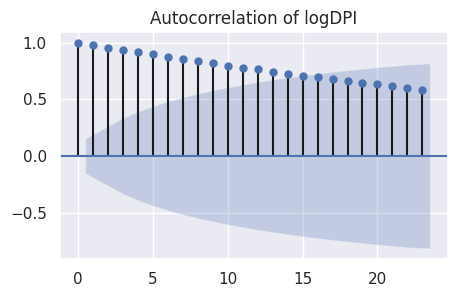

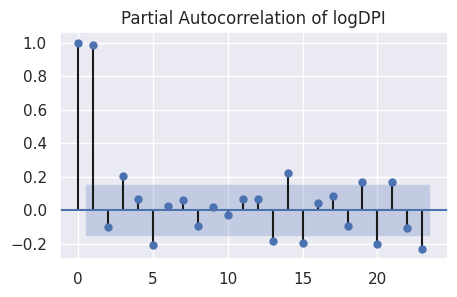

In [186]:
plt.rcParams.update({'figure.figsize':(5,3), 'figure.dpi':100}) 
plot_acf(train["logDPI"])
plt.title("Autocorrelation of logDPI") 

plt.rcParams.update({'figure.figsize':(5,3), 'figure.dpi':100}) 
plot_pacf(train["logDPI"])
plt.title("Partial Autocorrelation of logDPI") 
plt.show()

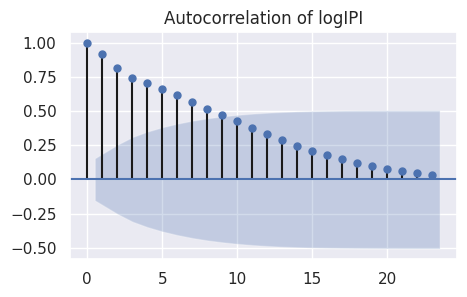

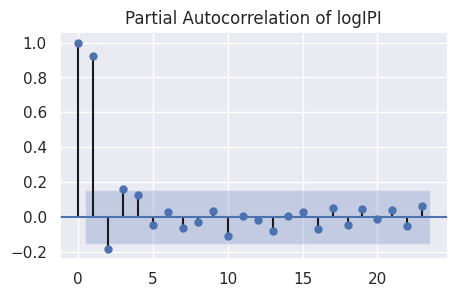

In [187]:
plot_acf(train["logIPI"])
plt.title("Autocorrelation of logIPI")

plot_pacf(train["logIPI"])
plt.title("Partial Autocorrelation of logIPI")
plt.show()

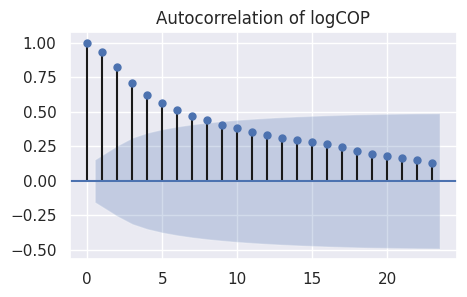

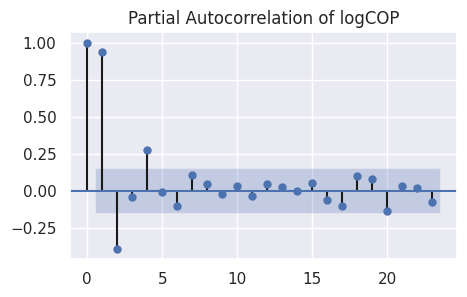

In [188]:
plot_acf(train["logCOP"])
plt.title("Autocorrelation of logCOP")

plot_pacf(train["logCOP"])
plt.title("Partial Autocorrelation of logCOP")
plt.show()

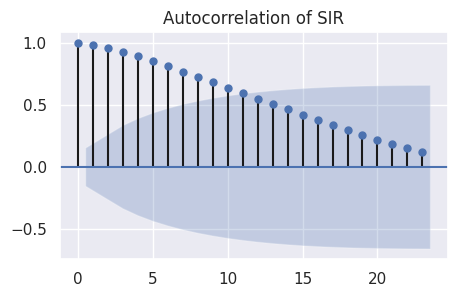

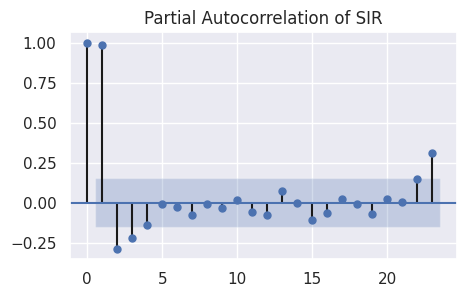

In [189]:
plot_acf(train["SIR"])
plt.title("Autocorrelation of SIR") 

plot_pacf(train["SIR"])
plt.title("Partial Autocorrelation of SIR")
plt.show()

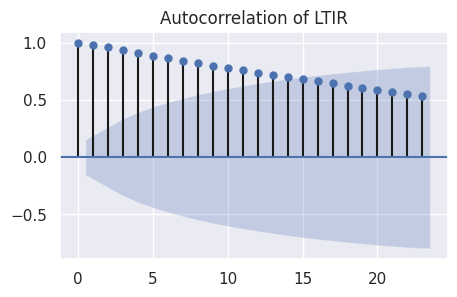

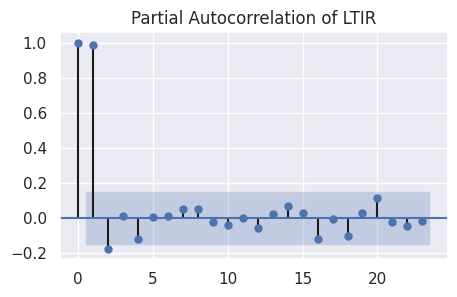

In [190]:
plot_acf(train["LTIR"])
plt.title("Autocorrelation of LTIR")

plot_pacf(train["LTIR"])
plt.title("Partial Autocorrelation of LTIR")
plt.show()

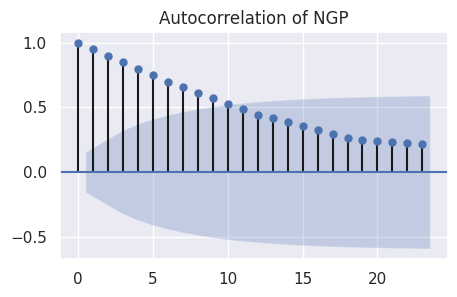

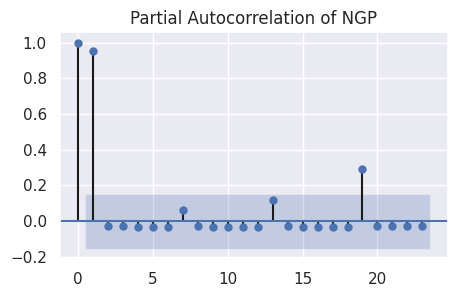

In [191]:
plot_acf(train["NGP"])
plt.title("Autocorrelation of NGP") 

plot_pacf(train["NGP"])
plt.title("Partial Autocorrelation of NGP") 
plt.show()

For each series, most of the autocorrelation are out of bounds and some partial autocorrelation too. This suggests that the series are not stationary. Below are presented the Augmented Dickey-Fuller (ADF) and the Phillips-Perron (PP) Tests which test the presence of an Unit Root.


## Test of the presence of an unit root :
### **Augmented Dickey-Fuller and Phillips-Perron Tests**

The null hypothesis to be tested is the presence of a unit root meaning that the series is not stationary. This test is based on an Autoregressive model with lag p (AR(p)) automatically determined by python and it assumes that the residuals are white noises. The model used is given below.
$$X_t-\mu=\sum_{i=1}^{p} \phi_i (X_{t-i}-\mu)+\epsilon_t$$

Unlike the ADF test, the Phillips-Perron (PP) test does not assume that the residuals are white noises. It is based on the same model as ADF and the same hypothesis is tested.

In [192]:
# This function is going to be used to directly test by ADF and PP tests the stationarity of each series 
def get_stationarity(timeseries):
    # Dickey–Fuller Test:
    result = adfuller(timeseries)
    print('ADF Test results of',timeseries.name )
    print('Lag :{}'.format(result[2]))
    print('Statistic  : {}'.format(result[0]))
    print('p-value : {}'.format(result[1]))
    print('critical test values :')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))
    #Phillips-Perron Test:
    result1= at.PhillipsPerron(timeseries, trend='ct', test_type="tau") 
    print()
    print('PP Test results of',timeseries.name )
    print('Statistic : {}'.format(result1.stat))
    print('p-value : {}'.format(result1.pvalue))
    print()

In [193]:
get_stationarity(train["logDPI"])
get_stationarity(train["logIPI"])
get_stationarity(train["logCOP"])
get_stationarity(train["SIR"])
get_stationarity(train["LTIR"])
get_stationarity(train["NGP"])


ADF Test results of logDPI
Lag :2
Statistic  : -0.8905825058138348
p-value : 0.791057911184364
critical test values :
	1%: -3.472161410886292
	5%: -2.8798954259680936
	10%: -2.5765565828092245

PP Test results of logDPI
Statistic : -2.5489560010244245
p-value : 0.30393341908543325

ADF Test results of logIPI
Lag :4
Statistic  : -1.8664900586983297
p-value : 0.3479856591420856
critical test values :
	1%: -3.472703119504854
	5%: -2.880131672353732
	10%: -2.5766826861130268

PP Test results of logIPI
Statistic : -2.6173100429904697
p-value : 0.2719893597319041

ADF Test results of logCOP
Lag :1
Statistic  : -2.9417290306943635
p-value : 0.04070623297779934
critical test values :
	1%: -3.4718957209472654
	5%: -2.8797795410156253
	10%: -2.5764947265625

PP Test results of logCOP
Statistic : -2.8645576746004404
p-value : 0.17424382972764962

ADF Test results of SIR
Lag :4
Statistic  : -2.2252086455864983
p-value : 0.19722370568654946
critical test values :
	1%: -3.472703119504854
	5%: -2.880

At the significant level of 5%, the null hypthesis is not rejected for any of the six series (because the p-value is greater than 5% for each series). So there is an Unit Root for each series, meaning that they are not stationary.

Also, the null hypothesis of the presence of an unit root is not rejected at a significant level of 5% for any of the 6 series, as with ADF test. So, none of these series is stationary.


## Stationarization of the series

Since each series seems to present a stochastic trend, the stationarization is going to be made by differenciating them until getting stationary series.


**Log of DPI (logDPI)**

ADF Test results of logDPI
Lag :1
Statistic  : -9.739848292784547
p-value : 8.553558255663937e-17
critical test values :
	1%: -3.472161410886292
	5%: -2.8798954259680936
	10%: -2.5765565828092245

PP Test results of logDPI
Statistic : -10.972495359760435
p-value : 2.510894356284906e-17



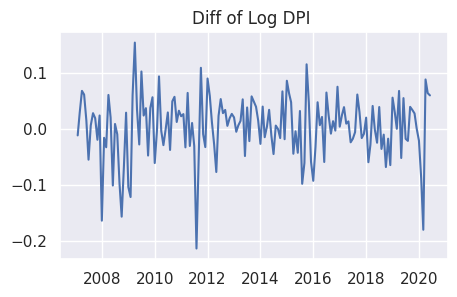

In [194]:
diff_logDPI= train["logDPI"].diff()
diff_logDPI.dropna(inplace=True)
get_stationarity(diff_logDPI)
plt.plot(diff_logDPI)
plt.title("Diff of Log DPI ")
plt.show()

There is no unit root (p-value < 5%), so LogDPI differenciated once is stationary. So LogDPI is integrated at 1 (it is I(1)).

**Log of IPI (logIPI)**

ADF Test results of logIPI
Lag :1
Statistic  : -10.592655623316508
p-value : 6.467984602144981e-19
critical test values :
	1%: -3.472161410886292
	5%: -2.8798954259680936
	10%: -2.5765565828092245

PP Test results of logIPI
Statistic : -11.12665693225264
p-value : 1.2848547003692406e-17



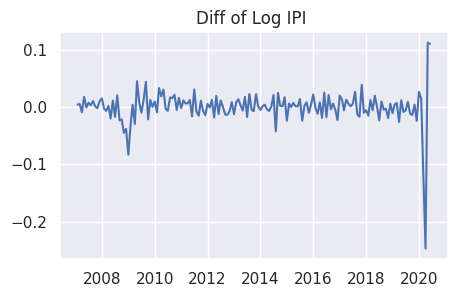

In [195]:
diff_logIPI= train["logIPI"].diff()
diff_logIPI.dropna(inplace=True)
get_stationarity(diff_logIPI)
plt.plot(diff_logIPI)
plt.title("Diff of Log IPI ")
plt.show()

There is no unit root (p-value < 5%), so LogIPI differenciated once is stationary. So LogIPI is integrated at 1 (it is I(1)).

**Log of COP (logCOP)**

ADF Test results of logCOP
Lag :2
Statistic  : -7.5278231666178295
p-value : 3.644996436806477e-11
critical test values :
	1%: -3.4724305215713156
	5%: -2.8800127935315465
	10%: -2.576619230892485

PP Test results of logCOP
Statistic : -8.287658219360061
p-value : 1.5468596775763902e-11



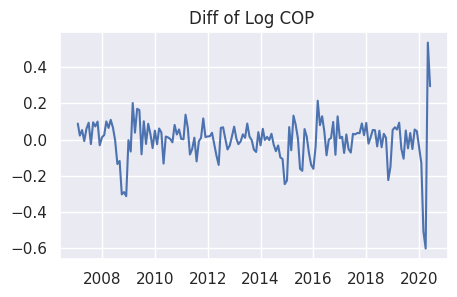

In [196]:
diff_logCOP= train["logCOP"].diff()
diff_logCOP.dropna(inplace=True)
get_stationarity(diff_logCOP)
plt.plot(diff_logCOP)
plt.title("Diff of Log COP ")
plt.show()

There is no unit root (p-value < 5%), so LogCOP differenciated once is stationary. So LogCOP is integrated at 1 (it is I(1)).

**SIR**

ADF Test results of SIR
Lag :3
Statistic  : -5.093495047920857
p-value : 1.444742212430789e-05
critical test values :
	1%: -3.472703119504854
	5%: -2.880131672353732
	10%: -2.5766826861130268

PP Test results of SIR
Statistic : -5.00597514612171
p-value : 0.0002006528956323723



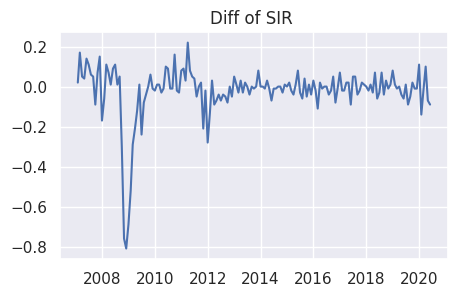

In [197]:
diff_SIR= train["SIR"].diff()
diff_SIR.dropna(inplace=True)
get_stationarity(diff_SIR)
plt.plot(diff_SIR)
plt.title("Diff of SIR ")
plt.show()

There is no unit root (p-value < 5%), so SIR differenciated once is stationary. So SIR is integrated at 1 (it is I(1)).

**LTIR**

ADF Test results of LTIR
Lag :4
Statistic  : -6.928995535448997
p-value : 1.0964262849314317e-09
critical test values :
	1%: -3.4729792729247793
	5%: -2.8802520918255534
	10%: -2.5767469641683105

PP Test results of LTIR
Statistic : -8.794634743491162
p-value : 1.0616518613165375e-12



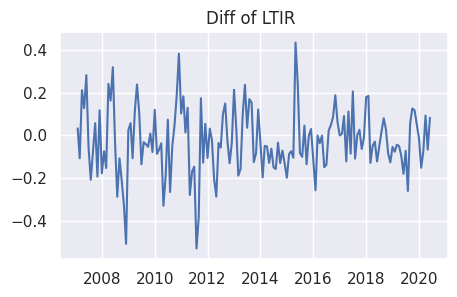

In [198]:
diff_LTIR= train["LTIR"].diff()
diff_LTIR.dropna(inplace=True)
get_stationarity(diff_LTIR)
plt.plot(diff_LTIR)
plt.title("Diff of LTIR ")
plt.show()

There is no unit root (p-value < 5%), so LTIR differenciated once is stationary. So LTIR is integrated at 1 (it is I(1)).


**NGP**

ADF Test results of NGP
Lag :0
Statistic  : -12.60326061198598
p-value : 1.7176996631371195e-23
critical test values :
	1%: -3.4718957209472654
	5%: -2.8797795410156253
	10%: -2.5764947265625

PP Test results of NGP
Statistic : -12.729994700779862
p-value : 3.101035127037736e-20



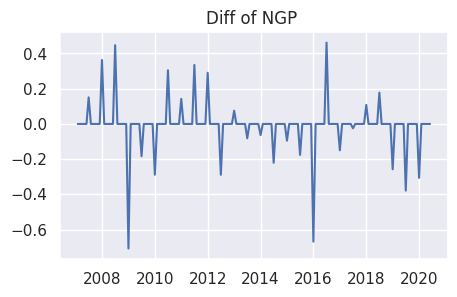

In [199]:
diff_NGP= train["NGP"].diff()
diff_NGP.dropna(inplace=True)
get_stationarity(diff_NGP)
plt.plot(diff_NGP)
plt.title("Diff of NGP ")
plt.show()

There is no unit root (p-value < 5%), so NGP differenciated once is stationary. So NGP is integrated at 1 (it is I(1)).

As each series is I(1), an Error Correction Model (ECM) could be applied if there is a cointegration between the series. 


 Now we move to the study of relationships between pairs of variables. We begin by plotting the dispersion matrix of data.

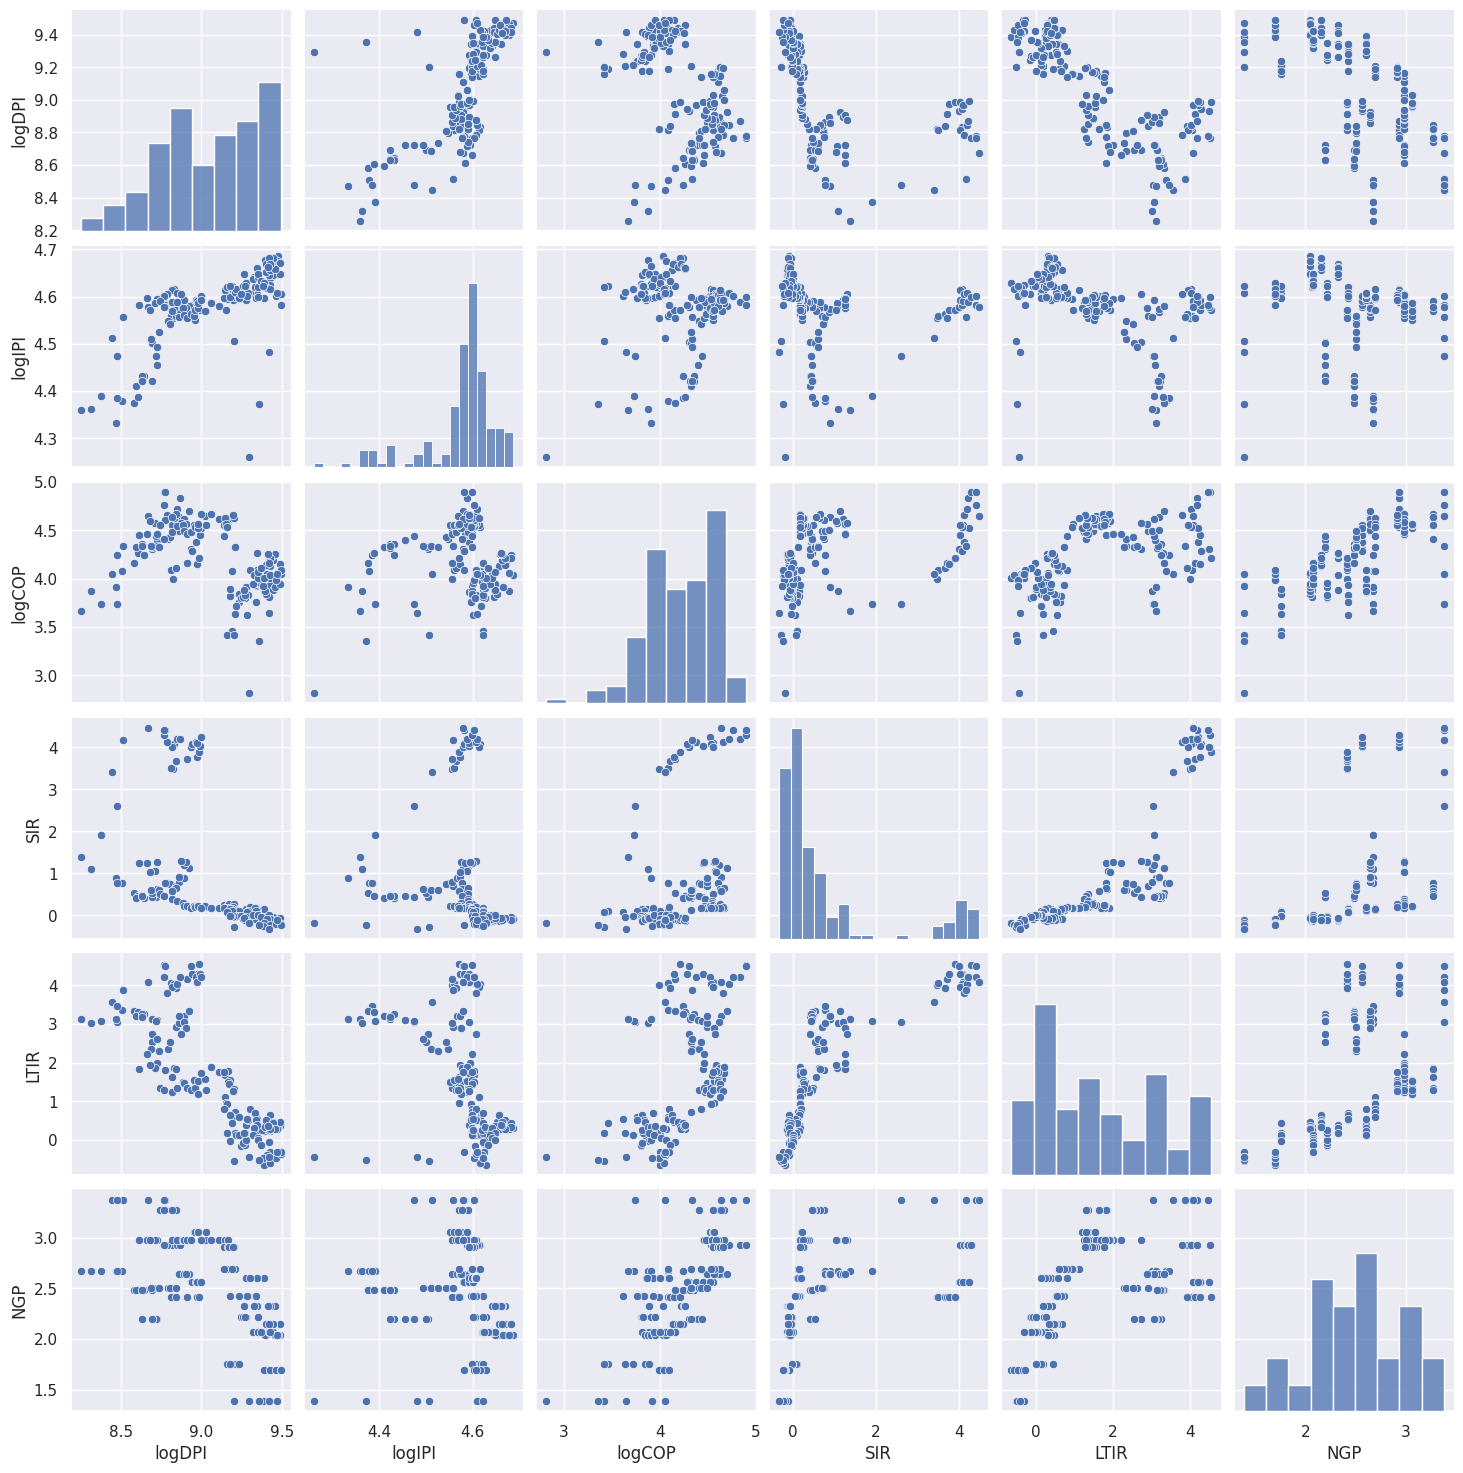

In [200]:
#Dispersion between the variables
cols=["logDPI","logIPI", "logCOP", "SIR", "LTIR", "NGP"]
sns.pairplot(train[cols])
plt.show()

[]

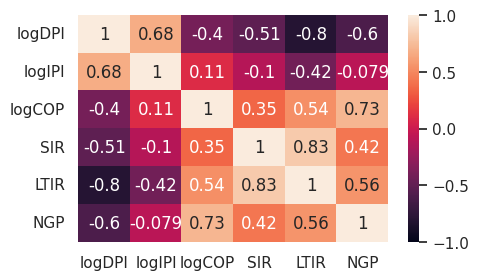

In [201]:
sns.heatmap(train[cols].corr(), vmin = -1, vmax = +1, annot = True)
plt.plot()

The plot between logDPI and LTIR exhibit a linear relationship and the coreelation between them is high (-0.8). The correlation between logDPI and logIPI, NGP, SIR and logCOP is not so negligible. So we can check if there is a cointegration between these variables. 

### **Check for causality by using Granger's causality test**

The null hypothesis tested is the absence of causality between two variables

In [202]:
maxlag=12
test1 = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(train[cols], variables = train[cols].columns) 

,logDPI_x,logIPI_x,logCOP_x,SIR_x,LTIR_x,NGP_x
logDPI_y,1.0000,0.0374,0.0330,0.0000,0.0000,0.0531
logIPI_y,0.0000,1.0000,0.0000,0.0000,0.0483,0.0193
logCOP_y,0.0000,0.0000,1.0000,0.0274,0.0414,0.0332
SIR_y,0.0001,0.0017,0.0027,1.0000,0.0735,0.0069
LTIR_y,0.0138,0.3811,0.0021,0.5798,1.0000,0.2728
NGP_y,0.0031,0.1403,0.0000,0.0000,0.0011,1.0000


The table above presents the different p-values of the test of Granger of the absence of causality between two variables. explained variables are indexed with y (in row) and explicables variables are indexed with x (in columns)

For instance, at the significance level of $5\%$, logIPI, logCOP, SIR and LTIR cause logDPI. logDPI, logIPI, logCOP, SIR, LTIR cause NGP. Each variable is caused by at least two other variables.

### **Check for cointegration using Johansen cointegration test**

The hypothesis tested are:

$H0: r=d$ (absence of cointegration when $d=0$) against $H1: r>d$  for $ p ∈\{0,1, 2, 3, 4, 5\}$ 

where $r$ is the order of cointegration. 

In [203]:
# Johansen Test assuming a drift
mod1=coint_johansen(train[cols], 0, 1)
johansen1=pd.DataFrame([mod1.eig,mod1.lr1, mod1.lr2], index=['Eigen value','Trace','Max eigen'], columns=['r=0','r=1','r=2','r=3','r=4','r=5'])
print("Critical Values for Trace Statistic :")
print("[sig. level : 90%  95%  99%]")
print()
print(mod1.cvt)
print("Critical Values for Maximum Eigen Value Statistic ")
print("[sig. level : 90%  95%  99%]")
print(mod1.cvm)
johansen1

Critical Values for Trace Statistic :
[sig. level : 90%  95%  99%]

[[ 91.109   95.7542 104.9637]
 [ 65.8202  69.8189  77.8202]
 [ 44.4929  47.8545  54.6815]
 [ 27.0669  29.7961  35.4628]
 [ 13.4294  15.4943  19.9349]
 [  2.7055   3.8415   6.6349]]
Critical Values for Maximum Eigen Value Statistic 
[sig. level : 90%  95%  99%]
[[37.2786 40.0763 45.8662]
 [31.2379 33.8777 39.3693]
 [25.1236 27.5858 32.7172]
 [18.8928 21.1314 25.865 ]
 [12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


,r=0,r=1,r=2,r=3,r=4,r=5
Eigen value,0.233621,0.170847,0.108016,0.061804,0.037379,0.004554
Trace,107.870674,65.298076,35.322021,17.032939,6.825562,0.730363
Max eigen,42.572598,29.976055,18.289083,10.207377,6.095200,0.730363


In [204]:
# Johansen Test assuming a deterministic trend
mod2=coint_johansen(train[cols], 1, 1)
johansen2=pd.DataFrame([mod2.eig,mod2.lr1, mod2.lr2], index=['Eigen value','Trace','Max eigen'], columns=['r=0','r=1','r=2','r=3','r=4','r=5'])
print("Critical Values for Trace Statistic :")
print("[sig. level : 90%  95%  99%]")
print()
print(mod2.cvt)
print("Critical Values for Maximum Eigen Value Statistic ")
print("[sig. level : 90%  95%  99%]")
print(mod2.cvm)
johansen2

Critical Values for Trace Statistic :
[sig. level : 90%  95%  99%]

[[102.4674 107.3429 116.9829]
 [ 75.1027  79.3422  87.7748]
 [ 51.6492  55.2459  62.5202]
 [ 32.0645  35.0116  41.0815]
 [ 16.1619  18.3985  23.1485]
 [  2.7055   3.8415   6.6349]]
Critical Values for Maximum Eigen Value Statistic 
[sig. level : 90%  95%  99%]
[[40.5244 43.4183 49.4095]
 [34.4202 37.1646 42.8612]
 [28.2398 30.8151 36.193 ]
 [21.8731 24.2522 29.2631]
 [15.0006 17.1481 21.7465]
 [ 2.7055  3.8415  6.6349]]


,r=0,r=1,r=2,r=3,r=4,r=5
Eigen value,0.261769,0.175431,0.123798,0.070949,0.055589,0.012010
Trace,123.427300,74.867437,44.004228,22.858839,11.084156,1.933168
Max eigen,48.559863,30.863209,21.145388,11.774683,9.150988,1.933168


The trace statistic shows whether the sum of the eigenvalues is 0. The null hypothesis, $r=0$ gives a trace statistic of 123.427 assuming there is a drift, hence the null hypothesis can be rejected at 10, 5 and 1% confidence levels , as the magnitude of the trace statistic is greater than any of the critical values (102.467, 107.343 and 116.983). 

The null hypothesis, $r=1$ gives a trace statistic of 74.867, hence the null hypothesis cannot be rejected at 10, 5 and 1% confidence levels , as the magnitude of the trace statistic is lower than any of the critical values (75.103,  79.342 and  87.775). 

The eigenvalues stored in decreasing order of magnitude, show how strongly cointegrated the series are or how strong is the tendency to mean revert. 
The Maximum Eigen Value Statistic corresponds to the linear combinaison of these variables that has the greatest mean-reverting property.
Here, The Maximum Eigen Value Statistic for the null hypothesis $r=0$ (which is 48.560)  is rejected at 10 and 5% confidence levels (critical values: 40.524 and 43.418). And it is not rejected for the null hypothesis $r=1$. 
The interpretation is the same when assuming there is a deterministic trend.

Thus there is a cointegration between these variables and the cointegration order is 1.

As the variables are cointegrated, we are going to perform a VECM of them.

## **Vector Error Correction Model**

Error-correction models make it possible to specify long-term stable relationships while jointly analyzing the short-term dynamics between variables that are individually non-stationary but whose linear combination is stationary. In our case, the variables considered are I(1) and are cointegrated of order 1.

The model is specified as followed :

$$ΔY_t= -γ\hat{z}_{t-1} + \sum_i a_iΔX_{t-i}+\sum_jb_j\Delta Y_{t-j}+ϵ_t$$
Where:

$t$ is time,

$Y$ is the response variable, 

$X$ is the vector of exogenous variables, 

$\epsilon$ is a white noise and

$\hat{z}_{t-1}$ is the residual estimated by the long run relation lagged by one period: $$\hat{z}_{t-1}=Y_{t-1} -\hat{\alpha}-\hat{\beta}X_{t-1}$$ 


### **Selection of the lag order p**

To do so, we perform VAR models with different lags $p$ on variables at level (without differenciation) and use criteria like the Akaike Information Criteria (AIC) or the Bayesian Information Criteria (BIC) to choose the best lag, by choising the model with the minimum criteria.

In [205]:
model = VAR(train[cols])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  periods=len(index) + 1,


In [206]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,-15.21,-15.09,2.474e-07,-15.16
1,-30.44,-29.60*,6.000e-14,-30.10
2,-31.03*,-29.46,3.354e-14*,-30.39*
3,-31.02,-28.73,3.399e-14,-30.09
4,-30.99,-27.98,3.539e-14,-29.77
5,-30.87,-27.14,4.059e-14,-29.35
6,-30.70,-26.24,4.961e-14,-28.89
7,-30.64,-25.47,5.430e-14,-28.54
8,-30.50,-24.60,6.568e-14,-28.11
9,-30.34,-23.72,8.249e-14,-27.65


The best lag order is $p=2$ according to AIC, FPE and HQIC criteria, which corresponds to a VAR(2).

Considering logDPI as the response variable, the Error Correction Model equation is :

$$ΔlogDPI_t= -γ\hat{z}_{t-1} +  a_{11} ΔlogIPI_{t-1} + a_{21}ΔlogCOP_{t-1} +a_{31}ΔSIR_{t-1}+a_{41}ΔLTIR_{t-1}+a_{51}ΔNGP_{t-1}+a_{12}ΔlogIPI_{t-2}+a_{22}ΔlogCOP_{t-2}+a_{32}ΔSIR_{t-2}+a_{42}ΔLTIR_{t-2}+a_{52}ΔNGP_{t-2}+ b_1 \Delta Y_{t-1}+ b_2 \Delta Y_{t-2}+ϵ_t$$

and the long run relation is:

$$\hat{z}_{t-1}=logDPI_{t-1} -\hat{\alpha}-\hat{\beta_2}logIPI_{t-1}-\hat{\beta_3}logCOP_{t-1}-\hat{\beta_4}SIR_{t-1}-\hat{\beta_5}LTIR_{t-1}-\hat{\beta_6}NGP_{t-1}$$


For the long run relation to hold and assure the mean-reversion, $\gamma$ must be negative and lower than 1 in magnitude.

### **Train VECM(2)**

In [207]:
model_train=VECM(train[cols],k_ar_diff=2, coint_rank=1, deterministic='na')
model_fitted = model_train.fit()
print(model_fitted.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation logDPI
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.logDPI      0.0941      0.079      1.189      0.234      -0.061       0.249
L1.logIPI     -0.2251      0.202     -1.112      0.266      -0.622       0.172
L1.logCOP      0.1029      0.050      2.051      0.040       0.005       0.201
L1.SIR         0.1388      0.047      2.938      0.003       0.046       0.231
L1.LTIR       -0.0619      0.033     -1.893      0.058      -0.126       0.002
L1.NGP        -0.0023      0.035     -0.066      0.947      -0.071       0.067
L2.logDPI     -0.1924      0.085     -2.252      0.024      -0.360      -0.025
L2.logIPI     -0.2401      0.194     -1.238      0.216      -0.620       0.140
L2.logCOP      0.0371      0.055      0.678      0.498      -0.070       0.144
L2.SIR        -0.0567      0.051     -1.122  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  periods=len(index) + 1,


The results of the table above show that $\gamma$ (the coefficient ec1)corresponding to the endogenous variable logDPI is negative, lower than 1 in magnitude and significant at 5% significance level. This means that the mean-reversion is satisfied.

The coefficient of the long run relation (the coefficients beta.i) are all significant at 10, 5 and 1% significance levels, meaning the long run relationship is significant.

### **Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic**

It is used to identify if residuals are correlated or not. The statistic is calculated as :$$DW=\frac{\sum_{t=2}(e_t-e_{t-1})^2}{\sum_{t=1}e_t^2}$$
The value of this statistic can vary between 0 and 4. The closer it is to the value 2, then there is no significant serial correlation. The closer to 0, there is a positive serial correlation, and the closer it is to 4 implies negative serial correlation.

In [208]:
out = durbin_watson(model_fitted.resid)

for col, val in zip(train.columns, out):
    print(train[col].name, ':', round(val, 2))

DPI : 2.01
IPI : 2.04
COP : 2.01
SIR : 2.02
LTIR : 1.93
NGP : 1.95


The values of the DW statistic for all the 6 variables are close to 2, so there is no significant correlation between residuals.

### **Ljung Box test of absence of autocorrelation**

Null hypothesis : Absence of autocorrelation

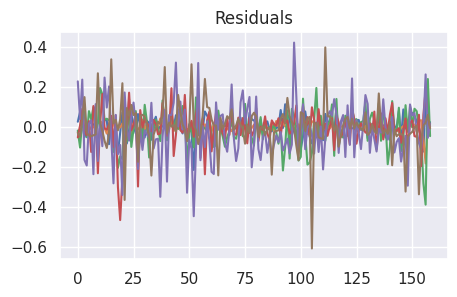


Ljung Box Test results
Statistic:  [8.45830034]
P-value:  [0.13272125]


In [209]:
plt.plot(model_fitted.resid)
plt.title("Residuals")
plt.show()
ljungbox=sm.stats.acorr_ljungbox(model_fitted.resid[1], lags=[5])
print()
print("Ljung Box Test results")
print("Statistic: ",ljungbox[0])
print("P-value: ",ljungbox[1])

At the significance level of 5%, we can conclude that the residuals are not autocorrelated. By seing the graph above, we can conclude that the mean and the variance are constant. Then the residuals are white noise. 

We can continue with predictions

## **Forcasting and comparison with the test sample**

On the 6 last months of the train data

In [226]:
print("Real value:")
test[cols]

Real value:


,logDPI,logIPI,logCOP,SIR,LTIR,NGP
Date,,,,,,
2020-07-01,9.418440,4.499726,3.707947,-0.33,-0.523043,1.3372
2020-08-01,9.468494,4.503054,3.746912,-0.34,-0.523333,1.3372
2020-09-01,9.454128,4.527125,3.679586,-0.36,-0.524091,1.3372
2020-10-01,9.355002,4.557995,3.677819,-0.36,-0.607273,1.3372
2020-11-01,9.494854,4.570495,3.716738,-0.37,-0.614762,1.3372
2020-12-01,9.526521,4.574628,3.851636,-0.42,-0.618500,1.3372
2021-01-01,9.505460,4.575658,3.953165,-0.23,-0.583500,2.0592
2021-02-01,9.531430,4.555897,4.078554,-0.26,-0.445500,2.0592
2021-03-01,9.616361,4.563223,4.132924,-0.12,-0.364783,2.0592


In [237]:
print("Forcast: ")
forecast=pd.DataFrame(model_fitted.predict(steps=12), index=test[cols].index, columns=test[cols].columns)
forecast

Forcast: 


,logDPI,logIPI,logCOP,SIR,LTIR,NGP
Date,,,,,,
2020-07-01,9.372188,4.428465,3.478935,-0.281789,-0.345589,1.453016
2020-08-01,9.334185,4.372661,3.290879,-0.168793,-0.311092,1.447644
2020-09-01,9.345612,4.386994,3.329894,-0.147449,-0.367828,1.455274
2020-10-01,9.355664,4.411291,3.387999,-0.160567,-0.389751,1.458313
2020-11-01,9.338375,4.401969,3.344796,-0.149605,-0.380537,1.470188
2020-12-01,9.322085,4.384965,3.283130,-0.127032,-0.382018,1.477527
2021-01-01,9.319904,4.383325,3.272525,-0.123257,-0.401064,1.480336
2021-02-01,9.319674,4.387324,3.278779,-0.131050,-0.413768,1.481471
2021-03-01,9.313876,4.384737,3.265235,-0.134247,-0.416113,1.483902


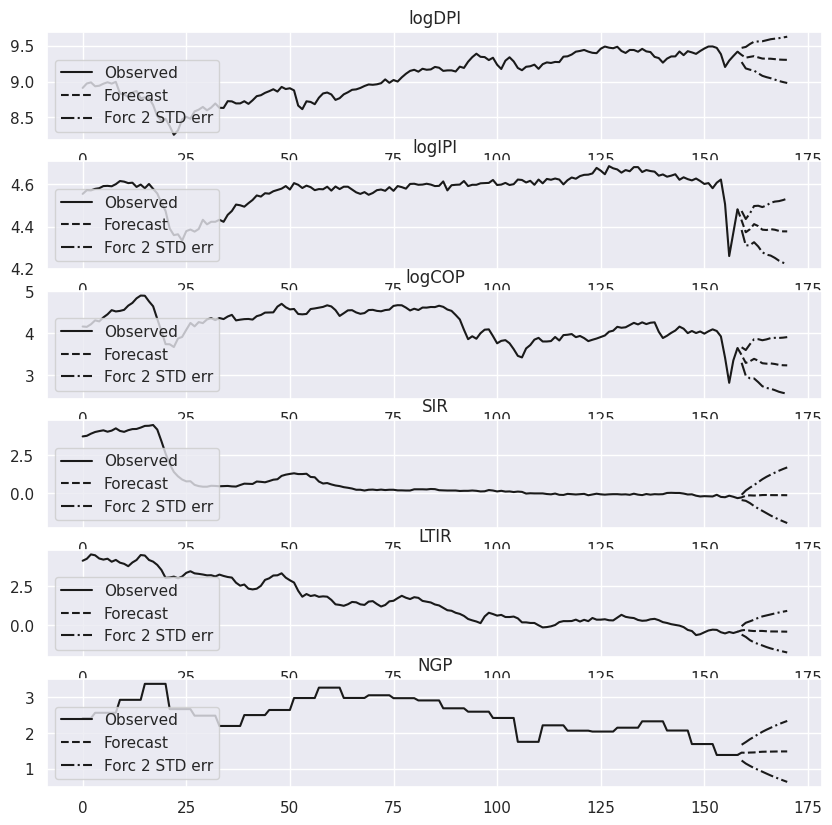

In [223]:
# Graph of observed and forcast series
register_matplotlib_converters()
model_fitted.plot_forecast(12)

In [260]:
# Forcasting: Returning back to the series without the log 
def invert_transformation(train, forecast):
    """Revert back the log to get the forecast to original scale."""
    df_fc = forecast.copy()
    columns = ["logDPI", "logIPI", "logCOP"]
    for col in columns:        
        # remove de log by exponantiating
        df_fc[str(col[3:])+'_forecast'] = np.exp(forecast[col])
    return df_fc
df_results =invert_transformation(train, forecast)

df_results1=df_results [["DPI_forecast", 	"IPI_forecast", 	"COP_forecast", "SIR", "LTIR", "NGP"]]
df_results1.rename(columns={"DPI_forecast":"DPI_forecast", 	"IPI_forecast":"IPI_forecast", 	"COP_forecast":"COP_forecast", 	"SIR" :"SIR_forecast",	"LTIR":"LTIR_forecast", 	"NGP":"NGP_forecast"}, inplace=True)
df_results1

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,DPI_forecast,IPI_forecast,COP_forecast,SIR_forecast,LTIR_forecast,NGP_forecast
Date,,,,,,
2020-07-01,11756.809991,83.802710,32.425176,-0.281789,-0.345589,1.453016
2020-08-01,11318.397104,79.254237,26.866457,-0.168793,-0.311092,1.447644
2020-09-01,11448.480346,80.398399,27.935382,-0.147449,-0.367828,1.455274
2020-10-01,11564.140089,82.375781,29.606649,-0.160567,-0.389751,1.458313
2020-11-01,11365.922452,81.611400,28.354783,-0.149605,-0.380537,1.470188
2020-12-01,11182.272935,80.235433,26.659080,-0.127032,-0.382018,1.477527
2021-01-01,11157.910449,80.103976,26.377871,-0.123257,-0.401064,1.480336
2021-02-01,11155.343540,80.424880,26.543349,-0.131050,-0.413768,1.481471
2021-03-01,11090.847773,80.217135,26.186259,-0.134247,-0.416113,1.483902


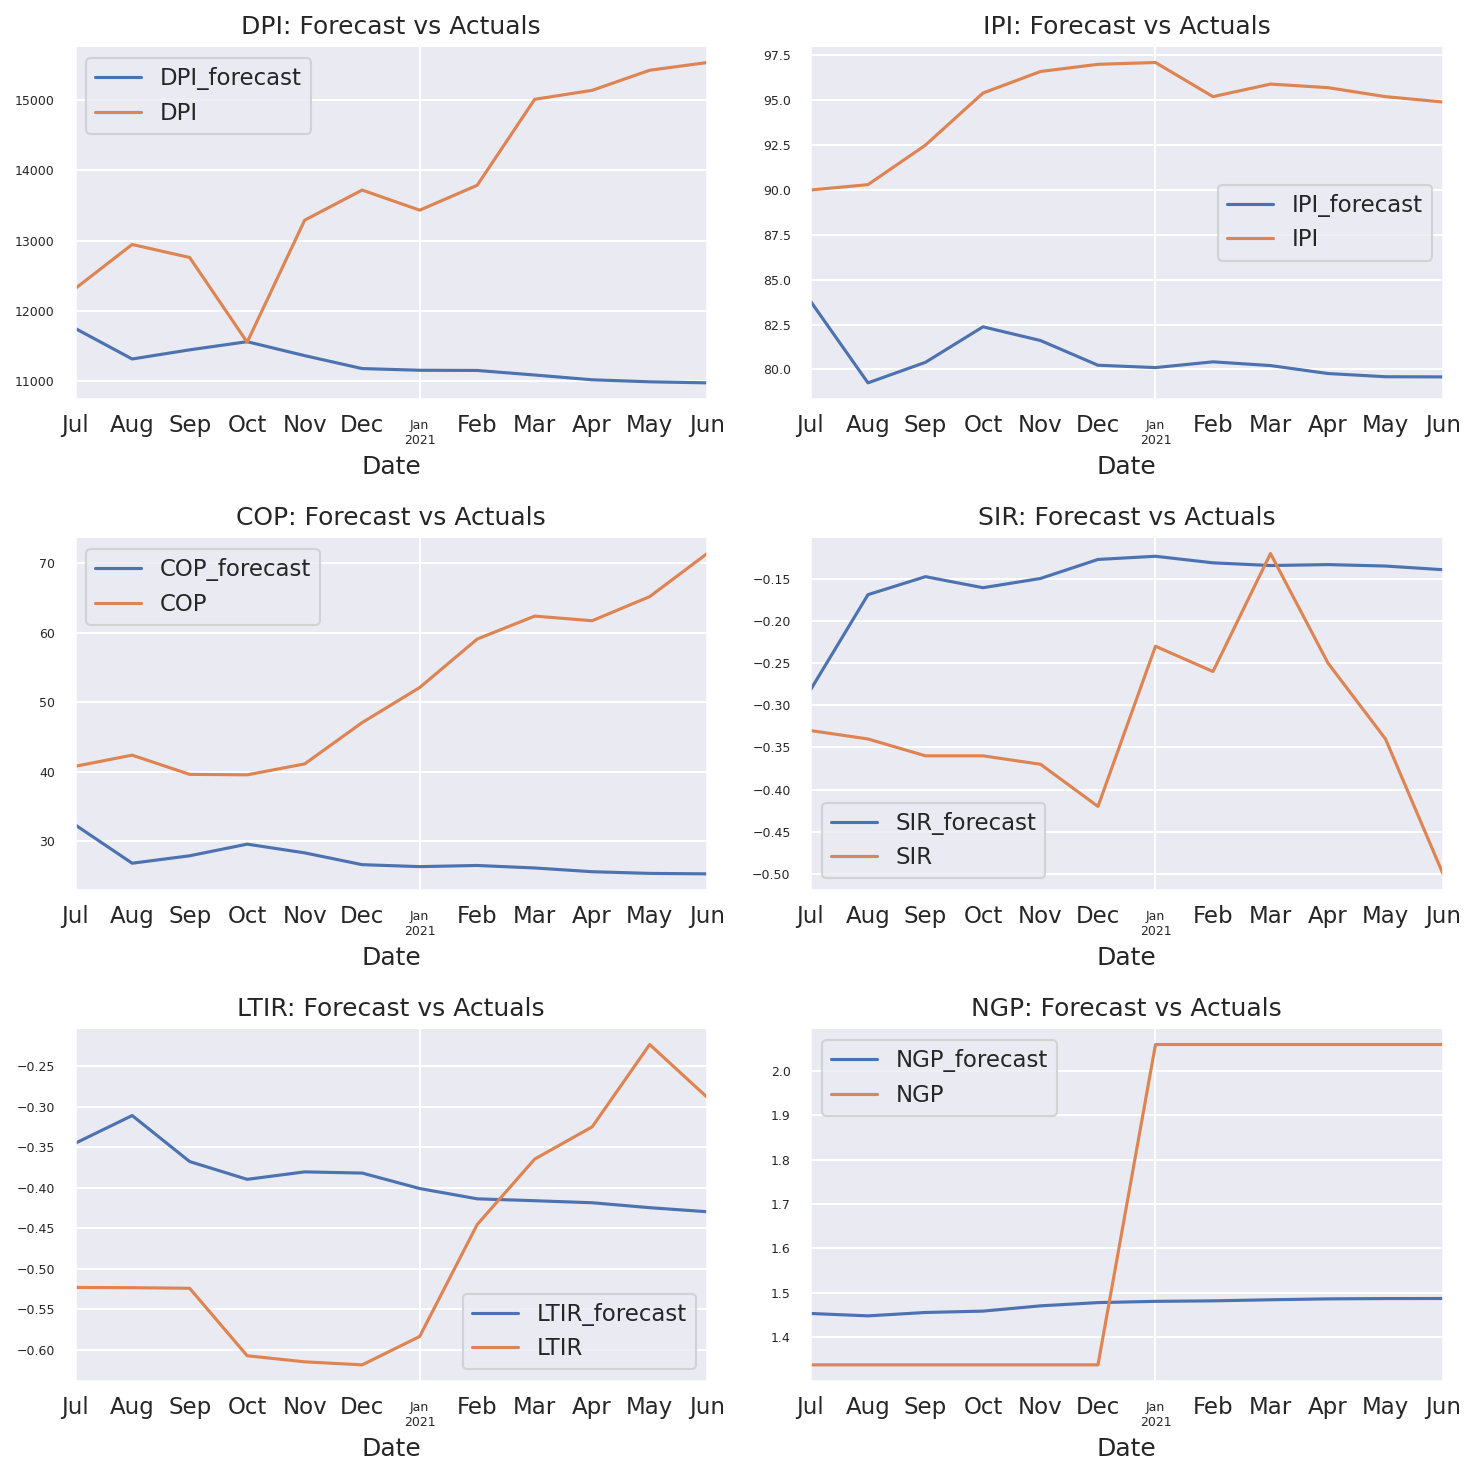

In [261]:
# Graphs of forcast and observed series (test sample)
cols=["DPI" ,	"IPI" ,	"COP" ,	"SIR", 	"LTIR", 	"NGP"]
fig, axes = plt.subplots(nrows=int(len(test[cols].columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(test[cols].columns, axes.flatten())):
    df_results1[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    test[col].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

###**Impulse Response Function**

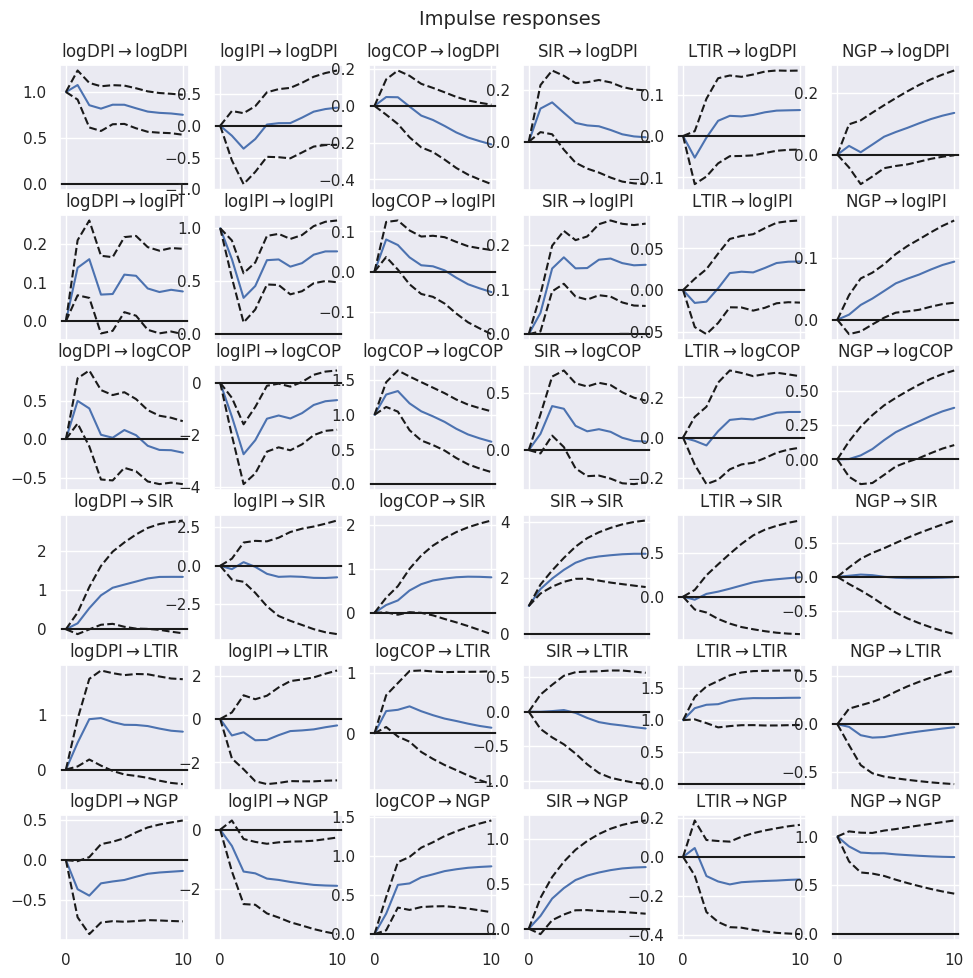

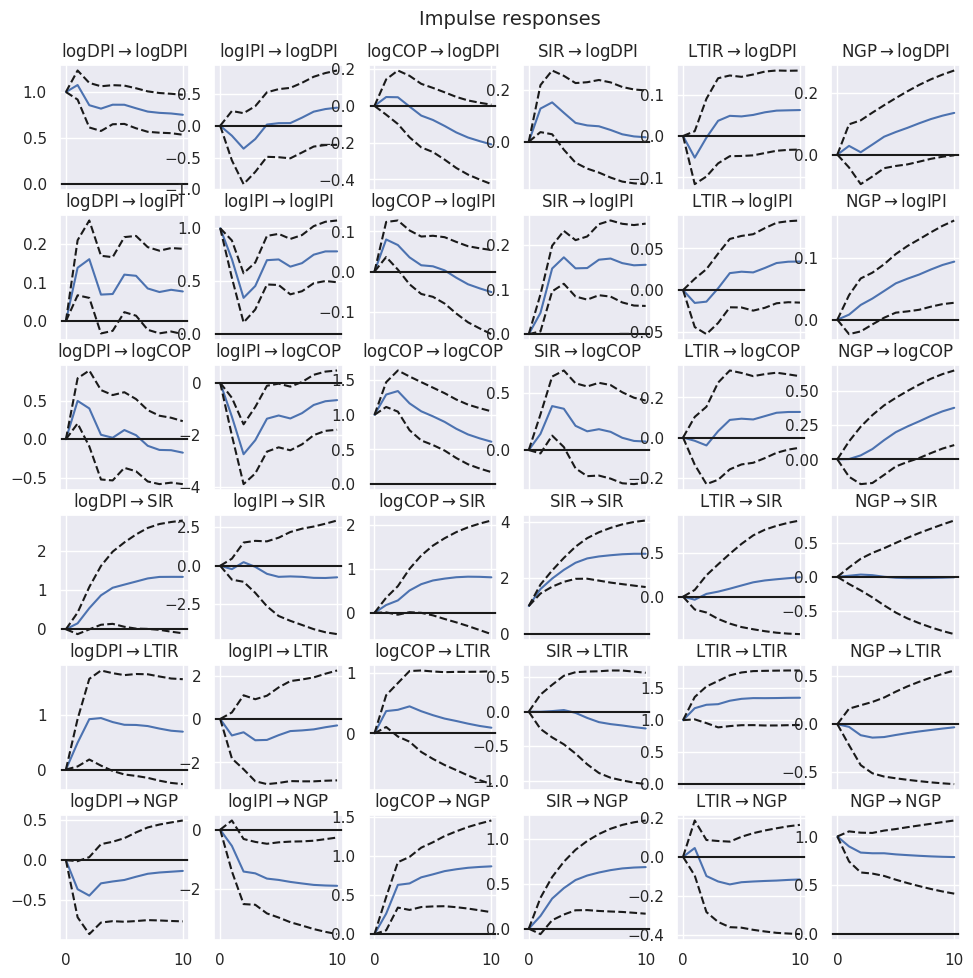

In [232]:
model_fitted.irf().plot()